In [ ]:
!nvidia-smi

Sun May 23 11:23:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
# %env KAGGLE_CONFIG_DIR=/content/drive/MyDrive/ML/

env: KAGGLE_CONFIG_DIR=/content/drive/MyDrive/ML/


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# !pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest

     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 163kB 54.4MB/s 


In [ ]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from resnest.torch import resnest50

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval
import timm

from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

# MAX_READ_SAMPLES = 5 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled
MAX_READ_SAMPLES = 10

# For colab
DATA_ROOT = Path("./datasets")
TRAIN_IMAGES_ROOT = Path("./datasets/audio_images")
TRAIN_LABELS_FILE = Path("./datasets/rich_train_metadata.csv")
MODEL_ROOT = Path("./sed_resnest50_fold0")

# DATA_ROOT = Path("../input/birdclef-2021")
# TRAIN_IMAGES_ROOT = Path("../input/kkiller-birdclef-2021/audio_images")
# TRAIN_LABELS_FILE = Path("../input/kkiller-birdclef-2021/rich_train_metadata.csv")

# MEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
# TRAIN_LABEL_PATHS = sorted(Path("../input").glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

MEL_PATHS = [Path(f'{DATA_ROOT}/rich_train_metadata.csv')]
TRAIN_LABEL_PATHS = [Path(f'{DATA_ROOT}/audio_images/LABEL_IDS.json')]

# MODEL_ROOT = Path(".")

In [ ]:
MEL_PATHS

[PosixPath('/content/datasets/rich_train_metadata.csv')]

In [ ]:
TRAIN_BATCH_SIZE = 100
TRAIN_NUM_WORKERS = 2

VAL_BATCH_SIZE = 128
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


## downloading dataset ...

In [ ]:
# %%time

# import os
# if not os.path.exists("/content/datasets/audio_images"):
#   !mkdir datasets
#   !kaggle datasets download -d kneroma/kkiller-birdclef-2021
#   print("unzipping ...")
#   !unzip /content//kkiller-birdclef-2021.zip -d datasets > /dev/null

100% 12.3G/12.3G [02:54<00:00, 48.9MB/s]
100% 12.3G/12.3G [02:54<00:00, 75.6MB/s]
unzipping ...
CPU times: user 2.78 s, sys: 564 ms, total: 3.34 s
Wall time: 6min 36s


In [ ]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
  df = None
  LABEL_IDS = {}
    
  for file_path in mel_paths:
    temp = pd.read_csv(str(file_path), index_col=0)
    temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    df = temp if df is None else df.append(temp)
    
  df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

  for file_path in train_label_paths:
    with open(str(file_path)) as f:
      LABEL_IDS.update(json.load(f))

  return LABEL_IDS, df

In [ ]:
df = pd.read_csv(TRAIN_LABELS_FILE, nrows=None)
df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df["primary_label"].unique()))}

print(df.shape)
df.head()

(62874, 20)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,label_id,filepath,frames,sr,duration,fold
0,acafly,[amegfi],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3
3,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4
4,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2


In [ ]:
df["primary_label"].value_counts()

rewbla     500
eursta     500
cubthr     500
houspa     500
redcro     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
crfpar       8
stvhum2      8
Name: primary_label, Length: 397, dtype: int64

In [ ]:
df["label_id"].min(), df["label_id"].max()

(0, 396)

In [ ]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """
    if "resnest" in name:
        model = timm.create_model(name, pretrained=False)
        model.load_state_dict(torch.load("/home/wangxiang/dat01/WWX/Competition/pretrained-model/cnn/resnest50-528c19ca.pth"))
    elif name.startswith("tf_efficientnet_b0_ns"):
        model = timm.create_model(name, pretrained=False)
        model.load_state_dict(torch.load("/home/wangxiang/dat01/WWX/Competition/pretrained-model/cnn/tf_efficientnet_b0_ns-c0e6a31c.pth"))

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

In [ ]:
def load_data(df):
    def load_row(row):
        impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(impath)[:MAX_READ_SAMPLES]
        # return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

## caching audio...

In [ ]:
# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

62874

shape: (10, 128, 281)


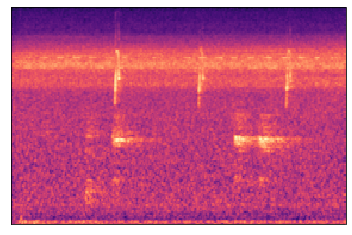

In [ ]:
print("shape:", next(iter(audio_image_store.values())).shape)
lbd.specshow(next(iter(audio_image_store.values()))[0])

# aug

In [ ]:
# https://github.com/ryanwongsa/kaggle-birdsong-recognition/blob/4ad1aa4ed99bc097289c7593c55bc09234e0fc59/src/augmentations/spec_augment.py

def multi_spec_augment(x):
    if len(x.shape) > 2:
        return np.stack([spec_augment(img) for img in x])
    return spec_augment(x)

def spec_augment(spec: np.ndarray,
                 num_mask=2,
                 freq_masking=0.15,
                 time_masking=0.20,
                 value=0):
    spec = spec.copy()
    num_mask = np.random.randint(1, num_mask)
    for i in range(num_mask):
        all_freqs_num, all_frames_num  = spec.shape
        freq_percentage = np.random.uniform(0.0, freq_masking)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[f0:f0 + num_freqs_to_mask, :] = value

        time_percentage = np.random.uniform(0.0, time_masking)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[:, t0:t0 + num_frames_to_mask] = value
    return spec

def gauss_augment(x):
  return x + np.random.normal(scale=12,size=audio_data.shape).astype('uint8')

In [ ]:
audio_img = next(iter(audio_image_store.values()))[0]

In [ ]:
def transform(x):
  if (np.random.rand() > 0.5):
    # if (np.random.rand() > 0.5):
    #   return gauss_augment(x)
    # else:
    return multi_spec_augment(x)
  else:
    return x

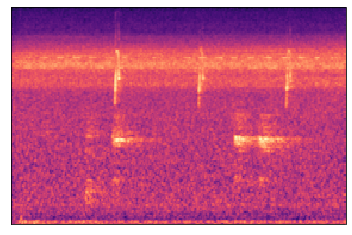

In [ ]:
lbd.specshow(transform(audio_img))

In [ ]:
pd.Series([len(x) for x in audio_image_store.values()]).value_counts()

10    22541
1      7271
2      5886
3      5625
4      5002
5      4303
6      3879
7      3166
8      2802
9      2399
dtype: int64

# dataset

In [ ]:
class BirdClefDataset(Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True,
                 num_classes=NUM_CLASSES, duration=DURATION, augment=False,
                 extra_labels=True):
        
        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr

        self.transform = augment
        self.extra_labels = extra_labels

    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        image = self.audio_image_store[row.filename]

        image = image[np.random.choice(len(image))]
        image = self.normalize(image)
        
        if (self.transform):
          image = transform(image)

        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        if (self.extra_labels):
          for sl in row.secondary_labels:
            if sl in LABEL_IDS:
              t[LABEL_IDS[sl]] = 0.995
        t[row.label_id] = 0.995
        
        return image, t

In [ ]:
ds = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(df)

62874

In [ ]:
# ds[62871] one that shows secondary labels

In [ ]:
random_choice = np.random.choice(len(ds))
x, y = ds[random_choice]
# x, y = ds[0]
x.shape, y.shape, np.where(y >= 0.5)

((3, 128, 281), (397,), (array([  5,  79,  92, 178, 318, 363]),))

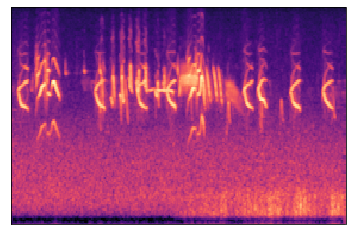

In [ ]:
lbd.specshow(x[0])

In [ ]:
y[:5]

array([0.0025, 0.0025, 0.0025, 0.0025, 0.0025], dtype=float32)

# validation

In [ ]:
!pip install gcsfs > /dev/null

In [ ]:
import gcsfs
gcs = gcsfs.GCSFileSystem()

GCS_BIRDCLEF = 'gs://kds-daa43f1212c8bed281e9c7a5a29053856385b753c580abc3a67f7361'

In [ ]:
import numpy as np
import librosa as lb
import soundfile as sf
import pandas as pd
import cv2
from pathlib import Path
import re

import torch
from torch import nn
from  torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

import time
from resnest.torch import resnest50

In [ ]:
import io

In [ ]:
NUM_CLASSES = 397
SR = 32_000
DURATION_INF = 5
THRESH = 0.25

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

TEST_AUDIO_ROOT = f"{GCS_BIRDCLEF}/train_soundscapes"
SAMPLE_SUB_PATH = None
TARGET_PATH = f"{GCS_BIRDCLEF}/train_soundscape_labels.csv"

DEVICE: cuda


In [ ]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):

        melspec = lb.feature.melspectrogram(
            y, sr=self.sr, n_mels=self.n_mels, fmin=self.fmin, fmax=self.fmax, **self.kwargs,
        )

        melspec = lb.power_to_db(melspec).astype(np.float32)
        return melspec

In [ ]:
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length):
    if len(y) < length:
        y = np.concatenate([y, length - np.zeros(len(y))])
    elif len(y) > length:
        y = y[:length]
    return y

In [ ]:
class BirdCLEFDatasetInference(Dataset):
    def __init__(self, data, sr=SR, n_mels=128, fmin=0, fmax=None, duration=DURATION_INF, step=None, res_type="kaiser_fast", resample=True):
        
        self.data = data
        
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.mel_spec_computer = MelSpecComputer(sr=self.sr, n_mels=self.n_mels, fmin=self.fmin,
                                                 fmax=self.fmax)
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def audio_to_image(self, audio):
        melspec = self.mel_spec_computer(audio) 
        image = mono_to_color(melspec)
        image = self.normalize(image)
        return image

    def read_file(self, filepath):

        # blob = gcs.blob(filepath)
        # file_as_string = blob.download_as_string()
        with gcs.open(filepath, 'rb') as f:
            file_as_string = f.read()
        audio, orig_sr = sf.read(io.BytesIO(file_as_string), dtype="float32")
        # audio, orig_sr = sf.read(filepath, dtype="float32")

        if self.resample and orig_sr != self.sr:
            audio = lb.resample(audio, orig_sr, self.sr, res_type=self.res_type)
          
        audios = []
        for i in range(self.audio_length, len(audio) + self.step, self.step):
            start = max(0, i - self.audio_length)
            end = start + self.audio_length
            audios.append(audio[start:end])
            
        if len(audios[-1]) < self.audio_length:
            audios = audios[:-1]
            
        images = [self.audio_to_image(audio) for audio in audios]
        images = np.stack(images)
        
        return images
    
        
    def __getitem__(self, idx):
        return self.read_file(self.data.loc[idx, "filepath"])

In [ ]:
data = pd.DataFrame(
     [(Path(path).stem, *Path(path).stem.split("_"), Path(path)) for path in gcs.glob(f"{TEST_AUDIO_ROOT}/*.ogg")],
    columns = ["filename", "id", "site", "date", "filepath"]
)
print(data.shape)
data['filepath'] = 'gcs://' + data['filepath'].astype(str)
data.head()

(20, 5)


,filename,id,site,date,filepath
0,10534_SSW_20170429,10534,SSW,20170429,gcs://kds-daa43f1212c8bed281e9c7a5a29053856385...
1,11254_COR_20190904,11254,COR,20190904,gcs://kds-daa43f1212c8bed281e9c7a5a29053856385...
2,14473_SSW_20170701,14473,SSW,20170701,gcs://kds-daa43f1212c8bed281e9c7a5a29053856385...
3,18003_COR_20190904,18003,COR,20190904,gcs://kds-daa43f1212c8bed281e9c7a5a29053856385...
4,20152_SSW_20170805,20152,SSW,20170805,gcs://kds-daa43f1212c8bed281e9c7a5a29053856385...


In [ ]:
df_train = pd.read_csv(f'{GCS_BIRDCLEF}/train_metadata.csv')

LABEL_IDS = {label: label_id for label_id,label in enumerate(sorted(df_train["primary_label"].unique()))}
INV_LABEL_IDS = {val: key for key,val in LABEL_IDS.items()}

In [ ]:
test_data = BirdCLEFDatasetInference(data=data)
len(test_data), test_data[0].shape

(20, (120, 3, 128, 201))

In [ ]:
def load_net(checkpoint_path, num_classes=NUM_CLASSES):
    net = resnest50(pretrained=False)
    net.fc = nn.Linear(net.fc.in_features, num_classes)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)
    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net = net.to(DEVICE)
    net = net.eval()
    return net

In [ ]:
@torch.no_grad()
def get_thresh_preds(out, thresh=None):
    thresh = thresh or THRESH
    o = (-out).argsort(1)
    npreds = (out > thresh).sum(1)
    preds = []
    for oo, npred in zip(o, npreds):
        preds.append(oo[:npred].cpu().numpy().tolist())
    return preds

In [ ]:
def get_bird_names(preds):
    bird_names = []
    for pred in preds:
        if not pred:
            bird_names.append("nocall")
        else:
            bird_names.append(" ".join([INV_LABEL_IDS[bird_id] for bird_id in pred]))
    return bird_names

In [ ]:
def predict(nets, test_data, names=True):
    preds = []
    with torch.no_grad():
        for idx in  tqdm(list(range(len(test_data))), leave=False):
            xb = torch.from_numpy(test_data[idx]).to(DEVICE)
            pred = 0.
            for net in nets:
                o = net(xb)
                o = torch.sigmoid(o)

                pred += o

            pred /= len(nets)
            
            if names:
                pred = get_bird_names(get_thresh_preds(pred))

            preds.append(pred)
    return preds

In [ ]:
def preds_as_df(data, preds):
    sub = {
        "row_id": [],
        "birds": [],
    }
    
    for row, pred in zip(data.itertuples(False), preds):
        row_id = [f"{row.id}_{row.site}_{5*i}" for i in range(1, len(pred)+1)]
        sub["birds"] += pred
        sub["row_id"] += row_id
        
    sub = pd.DataFrame(sub)
    
    if SAMPLE_SUB_PATH:
        sample_sub = pd.read_csv(SAMPLE_SUB_PATH, usecols=["row_id"])
        sub = sample_sub.merge(sub, on="row_id", how="left")
        sub["birds"] = sub["birds"].fillna("nocall")
    return sub

In [ ]:
def get_metrics(s_true, s_pred):
    s_true = set(s_true.split())
    s_pred = set(s_pred.split())
    n, n_true, n_pred = len(s_true.intersection(s_pred)), len(s_true), len(s_pred)
    
    prec = n/n_pred
    rec = n/n_true
    f1 = 2*prec*rec/(prec + rec) if prec + rec else 0
    
    return {"f1": f1, "prec": prec, "rec": rec, "n_label": n_true, "n_pred": n_pred, "n_match": n}

In [ ]:
sub_target = pd.read_csv(TARGET_PATH)

In [ ]:
@torch.no_grad()
def evaluate_samp(net):
    net.eval()

    l = 0
    lrap = 0

    pred_probas = predict([net], test_data, names=False)

    threshes = {}
    for thresh in tqdm(np.linspace(0.1,0.9,16+1)):
        preds = [get_bird_names(get_thresh_preds(pred, thresh=thresh)) for pred in pred_probas]
        threshes[f'{thresh:.3f}'] = preds_as_df(data, preds)

    best = {'f1': 0}

    for thresh, sub in threshes.items():  

      sub_target_merged = sub_target.merge(sub, how="left", on="row_id")
            
      df_metrics = pd.DataFrame([get_metrics(s_true, s_pred) for s_true, s_pred in zip(sub_target_merged.birds_x, sub_target_merged.birds_y)])

      (f1,prec,rec) = df_metrics.mean()[:3]
      if (f1 > best['f1']):
          best['f1'] = f1
          best['prec'] = prec
          best['rec'] = rec
          best['thresh'] = float(thresh)
          best['sub_target'] = sub_target.copy()

    return l, lrap, best['f1'], best['rec'], best['prec'], best['thresh']

# Training the Model

In [ ]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.50)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [ ]:
def one_epoch(net, criterion, optimizer, scheduler, train_loader, val_loader):
  net.train()
  l, lrap, prec, rec, f1, lr, icount = 0.,0.,0.,0., 0., 0., 0
  train_loader = tqdm(train_loader, leave = False)
  epoch_bar = train_loader
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec
      icount += 1

      lr += scheduler.get_last_lr()[0]

      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
            lr="{:.2e}".format(lr/icount),
          )

      # if(icount >= 1):
      #   break
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  lr /= icount
  
  # l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_loader)
  l_val, lrap_val, f1_val, rec_val, prec_val, thr = evaluate_samp(net)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), lr, thr

In [ ]:
class AutoSave:
  def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = f"{self.name}_{CACHE_TIMESTAMP}_logs"
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


In [ ]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True,
             save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"{SHORT_NAME}-birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  criterion = nn.BCEWithLogitsLoss()

  optimizer = optim.Adam(net.parameters(), lr=8e-4)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

  train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=DURATION, is_train=True)
  train_loader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
  val_loader = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), lr, thr = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=train_loader,
        val_loader=val_loader,
      )
  
    epoch_stats = f"[e{epoch:02d} lr{lr:.1e}] loss: ({l:.6f}, {l_val:.6f}) " \
          f"lrap: ({lrap:.3f}, {lrap_val:.3f}) f1: ({f1:.3f}, {f1_val:.3f}) " \
          f"rec: ({rec:.3f}, {rec_val:.3f}) prec: ({prec:.3f}, {prec_val:.3f}) " \
          f"thr: {thr:.2f}"

    epochs_bar.set_postfix_str(epoch_stats)

    print(epoch_stats)

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch, "lr": lr, "thr": thr
      }

      saver.log(net, metrics)

In [ ]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [ ]:
MODEL_NAMES = [
      "resnest50d",
] 

## training ...

In [ ]:
SHORT_NAME = 'new idea'
folds = [0]
epochs=12

In [ ]:
for model_name in MODEL_NAMES:
  print("\n\n###########################################", model_name.upper())
  try:
    CACHE_TIMESTAMP = time.strftime("%Y%m%d%H%M%S")
    suffix = f"_sr{SR}_d{DURATION}_{SHORT_NAME}"
    train(model_name, epochs=epochs, suffix=suffix, folds=folds, save=True)

  except Exception as e:
    # print(f"Error {model_name} : \n{e}")
    raise ValueError() from  e



########################################### RESNEST50



############################### [FOLD 0]


Downloading: "https://github.com/rwightman/pytorch-image-models/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth



[e00 lr8.0e-04] loss: (0.042207, 0.000000) lrap: (0.118, 0.000) f1: (0.008, 0.637) rec: (0.005, 0.637) prec: (0.275, 0.637) thr: 0.15



[e01 lr7.9e-04] loss: (0.034916, 0.000000) lrap: (0.372, 0.000) f1: (0.128, 0.643) rec: (0.072, 0.642) prec: (0.747, 0.644) thr: 0.15



[e02 lr7.5e-04] loss: (0.032214, 0.000000) lrap: (0.530, 0.000) f1: (0.293, 0.668) rec: (0.180, 0.666) prec: (0.809, 0.672) thr: 0.10



[e03 lr6.8e-04] loss: (0.030537, 0.000000) lrap: (0.617, 0.000) f1: (0.398, 0.667) rec: (0.263, 0.665) prec: (0.836, 0.675) thr: 0.15



[e04 lr6.0e-04] loss: (0.029287, 0.000000) lrap: (0.675, 0.000) f1: (0.470, 0.659) rec: (0.326, 0.658) prec: (0.852, 0.668) thr: 0.10



[e05 lr5.1e-04] loss: (0.028204, 0.000000) lrap: (0.721, 0.000) f1: (0.530, 0.673) rec: (0.383, 0.669) prec: (0.869, 0.683) thr: 0.15



[e06 lr4.0e-04] loss: (0.027252, 0.000000) lrap: (0.761, 0.000) f1: (0.577, 0.661) rec: (0.430, 0.658) prec: (0.883, 0.668) thr: 0.20



[e07 lr3.0e-04] loss: (0.026340, 0.000000) lrap: (0.795, 0.000) f1: (0.622, 0.690) rec: (0.478, 0.686) prec: (0.895, 0.703) thr: 0.20



[e08 lr2.1e-04] loss: (0.025453, 0.000000) lrap: (0.829, 0.000) f1: (0.665, 0.703) rec: (0.525, 0.699) prec: (0.911, 0.717) thr: 0.20



[e09 lr1.3e-04] loss: (0.024647, 0.000000) lrap: (0.857, 0.000) f1: (0.702, 0.695) rec: (0.567, 0.690) prec: (0.925, 0.710) thr: 0.20



[e10 lr6.3e-05] loss: (0.024004, 0.000000) lrap: (0.878, 0.000) f1: (0.732, 0.686) rec: (0.603, 0.681) prec: (0.935, 0.698) thr: 0.25



[e11 lr2.3e-05] loss: (0.023575, 0.000000) lrap: (0.893, 0.000) f1: (0.753, 0.693) rec: (0.628, 0.688) prec: (0.944, 0.707) thr: 0.20



# viz

In [ ]:
short_name = re.sub(r"[^\w_-]", "", SHORT_NAME)
extract_label = f"{model_name}{suffix}/{short_name}-birdclef_{model_name}_fold{folds[0]}_{CACHE_TIMESTAMP}"

In [ ]:
# baseline: "kneroma" + secondary labels (label = 0.995)
with open(MODEL_ROOT/'k2/secondl1-birdclef_resnest50_fold0_20210523085555_logs.json') as f:
    base_data = json.load(f)
base = pd.DataFrame(base_data)
# base = base.iloc[range(0,12)]
# base = base.rename(columns=dict(zip(base.columns,['base_' + key for key in base.columns])))

In [ ]:
save_log_path = MODEL_ROOT/f"{extract_label}_logs.json"
# save_log_path = '/content/drive/MyDrive/ML/BirdClef2021/models/resnest50_sr32000_d7_1e-3/1e-3-birdclef_resnest50_fold0_20210522123039_logs.json'
print(save_log_path)

/content/drive/MyDrive/ML/BirdClef2021/models/resnest50_sr32000_d7_specaug-12epochs/specaug-12epochs-birdclef_resnest50_fold0_20210523113426_logs.json


In [ ]:
with open(save_log_path) as f:
    new_data = json.load(f)
new = pd.DataFrame(new_data)
# new = new.rename(columns=dict(zip(new.columns,['new_' + key for key in new.columns])))

In [ ]:
epochs = max(base['epoch'].max(), new['epoch'].max())

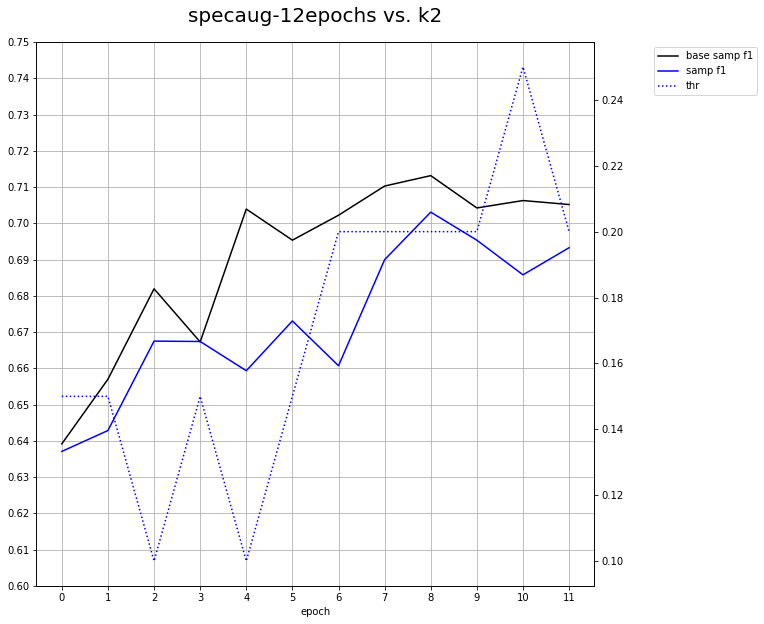

In [ ]:
fig,ax=plt.subplots(figsize=[10,10])

lines = []

lines.append([ax.plot(base['f1_val'],color='black')[0],'base samp f1'])
lines.append([ax.plot(new['f1_val'],color='blue')[0],'samp f1'])

plt.grid(axis='both')
plt.xticks(range(0,epochs+1))
plt.ylim(0.6,0.7)
plt.yticks(np.linspace(0.6,0.75,15 + 1))
plt.title(f'{SHORT_NAME} vs. k2', fontdict={'size': 20}, pad=20)
ax.set_xlabel('epoch')

ax2=ax.twinx()

lines.append([ax2.plot(new['thr'],':',color='blue')[0],'thr'])

ax.legend(
  [lines[i][0] for i in range(len(lines))],
  [lines[i][1] for i in range(len(lines))],
  loc='upper right', bbox_to_anchor=(1.3, 1))